In [1]:
# Import Dependencies and Setup
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL Toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Reflect an Existing Database into a New Model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We Can View All of the Classes That Automap Found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save References to Each Table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
#Create Our Session (Link) From Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

### Precipitation Analysis

In [8]:
# Determine Last Data Point by Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [9]:
# Calculate the Date One Year Ago From the Last Data Point in the Database
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [10]:
#Design a Query to Retrieve the Last 12 Months of Precipitation Data
prcp_data_one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
order_by(Measurement.date).all()

In [11]:
# Perform a Query to Retrieve the Data and Precipitation Scores
prcp_data_all = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()

In [12]:
# Save the Query Results as a Pandas DataFrame and Set the Index to the Date Column and Sort the DataFrame by Date
prcp_df = pd.DataFrame(prcp_data_one_year, columns=["Date", "Precipitation"])
prcp_df.set_index("Date", inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


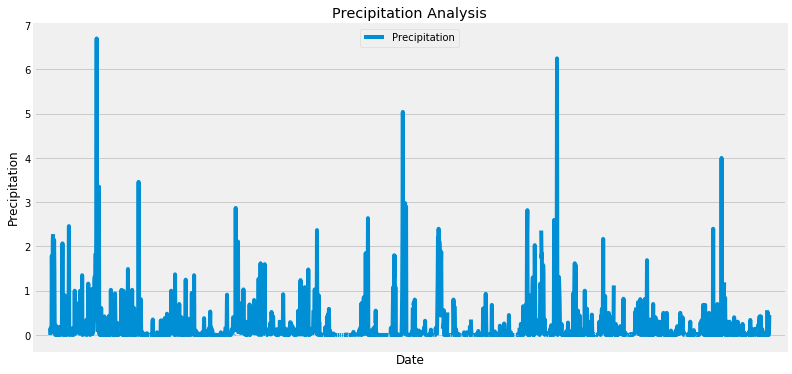

In [13]:
# Use Pandas Plotting with Matplotlib to Plot the Data
prcp_df.plot(figsize=(12,6))
plt.title("Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend(loc="upper center")
plt.xticks([])
plt.xlim(-50, len(prcp_df)+50)
plt.savefig("Output_Images/precipitation.png")
plt.show()

In [14]:
# Use Pandas to Calculate the Summary Statistics For the Precipitation Data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [15]:
# Design a Query to Show How Many Stations Are Available in This Dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [16]:
# Design a Query to Find the Most Active Stations and List the Stations and the Counts in Descending Order
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Calculate the Highest, Lowest, and Average Temperature Recorded of the Most Active Station
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
active_station_data = session.query(*sel).filter(Measurement.station == "USC00519281").all()
active_station_data

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the Station with the Highest Number of Temperature Observations
# Query the Last 12 Months of Temperature Observation Data For the Station
active_station_tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).\
filter(Measurement.station == "USC00519281").order_by(Measurement.date).all()

# Save Query Results as Pandas DataFrame
active_station_tobs_data_df = pd.DataFrame(active_station_tobs_data, columns=["TOBs"])
active_station_tobs_data_df.head()

,TOBs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


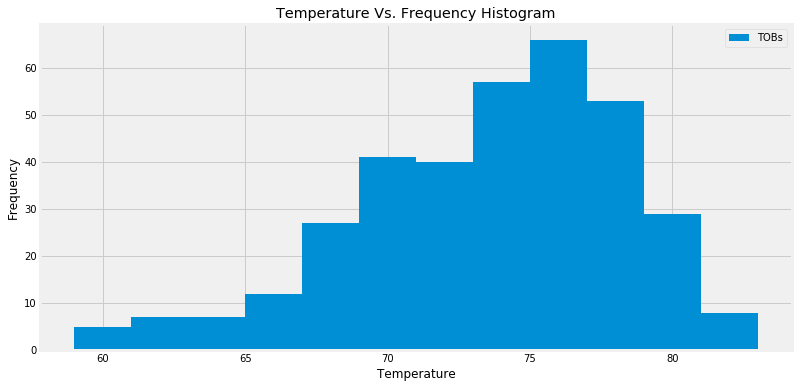

In [19]:
# Plot the Results as a Histogram
active_station_tobs_data_df.plot.hist(bins=12, figsize=(12,6))
plt.title("Temperature Vs. Frequency Histogram")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Output_Images/temperature_vs_frequency.png")

### Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function Usage Example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Calculate the TMIN, TAVG, and TMAX For Trip Using Previous Year's Data For the Specified Dates
# These Dates Are For a Real Hawaii Trip That I Took!
my_trip = calc_temps('2015-05-13', '2015-05-22')
my_trip

[(64.0, 73.43055555555556, 82.0)]

In [22]:
# Create a DataFrame of the Results
my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])
my_trip_df.head()

,TMIN,TAVG,TMAX
0,64.0,73.430556,82.0


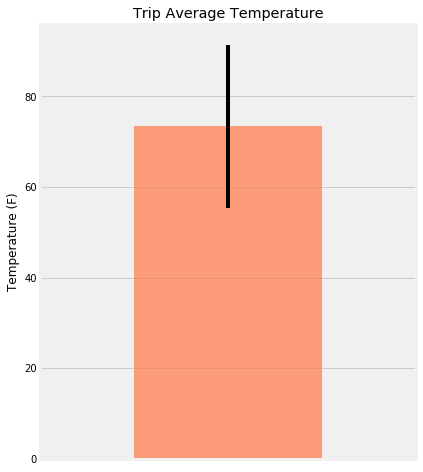

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df.plot.bar(y="TAVG", yerr=(my_trip_df["TMAX"] - my_trip_df["TMIN"]), color="coral", alpha=0.75, figsize=(6,8), legend=None)
plt.title("Trip Average Temperature")
plt.xticks([])
plt.ylabel("Temperature (F)")
plt.savefig("Output_Images/trip_average_temperature.png")
plt.show()